1. LOADING DATASET

In [1]:
import pandas as pd

# Load manually downloaded data
rf_data = pd.read_csv('TB3MS.csv')

# Ensure correct column names
rf_data.columns = ['observation_date', 'TB3MS']
rf_data['date'] = pd.to_datetime(rf_data['observation_date'])  # Convert date to datetime format
rf_data['yyyymm'] = rf_data['date'].dt.strftime('%Y%m').astype(int)  # Convert date to yyyymm
rf_data['rf'] = rf_data['TB3MS']
rf_data = rf_data[['yyyymm', 'rf']]  # Keep only relevant columns

# Merge with stock data
#df = df.merge(rf_data, on='yyyymm', how='left')


In [2]:
# Load the data
df = pd.read_csv('crspm_and_predictors.csv')

#df['yyyymm'] = pd.to_datetime(df['yyyymm'])  # Convert date to datetime format
#df['yyyymm'] = df['yyyymm'].dt.strftime('%Y%m').astype(int)  # Convert date to yyyymm

In [3]:
import pandas as pd

# Ensure yyyymm is an integer in stock data
df['yyyymm'] = df['yyyymm'].astype(int)

# Ensure risk-free rate data is formatted correctly
rf_data = rf_data[['yyyymm', 'rf']].drop_duplicates()  # Drop duplicates if any
rf_data['yyyymm'] = rf_data['yyyymm'].astype(int)  # Ensure integer format

# Merge with stock data
df = df.merge(rf_data, on='yyyymm', how='left')

# Check for missing risk-free rates after merging
missing_rf = df[df['rf'].isna()]['yyyymm'].unique()
if len(missing_rf) > 0:
    print(f"Warning: Missing risk-free rates for these months: {missing_rf}")


In [4]:
df.to_csv('merged_data.csv', index=False)

In [5]:
df.head()

,permno,yyyymm,prc,ret,Price,Size,STreversal,MaxRet,High52,RealizedVol,...,MomOffSeason06YrPlus,grcapx,EntMult,Investment,PctTotAcc,EarnSupBig,EarningsSurprise,BetaTailRisk,CBOperProf,rf
0,10659,199102,-0.17188,-15.3846,1.760959,-8.844859,15.3846,0.000000,0.407414,-0.035295,...,NaN,0.799007,NaN,NaN,0.795044,-0.379424,-0.109776,NaN,-0.371791,5.94
1,10659,199103,-0.10938,-36.3636,2.212927,-8.392890,36.3636,0.000000,0.259268,-0.065733,...,NaN,0.799007,NaN,NaN,0.795044,-0.483346,-0.109776,NaN,-0.371791,5.91
2,10659,199104,-0.21875,100.0000,1.519826,-9.085992,-100.0000,-0.571429,0.518512,-0.127870,...,NaN,0.802281,NaN,-0.043613,0.439730,-0.470160,-0.050594,NaN,-0.138481,5.65
3,10659,199105,-0.21875,0.0000,1.519826,-9.085992,0.0000,-0.142857,0.518512,-0.045962,...,NaN,0.802281,NaN,-0.046697,0.439730,-0.498256,-0.050594,NaN,-0.138481,5.46
4,10659,199106,-0.20313,-7.1429,1.593909,-9.011908,7.1429,0.000000,0.481488,-0.015972,...,NaN,0.802281,NaN,-0.050251,0.439730,-0.116901,-0.050594,NaN,-0.138481,5.57


2. Generating Forward-looking features for target

In [6]:

data = df.copy()

# Make sure the data is still ordered by permno and yyyymm, and apply shift per permno group
data['ret_fwd'] = data.groupby('permno')['ret'].shift(-1)

# Drop rows with NaN values in the ret_fwd column
data = data.dropna(subset=['ret_fwd'])

# Then calculate the excess return
data['excess_ret'] = data['ret_fwd'] - data['rf']


data.head()

,permno,yyyymm,prc,ret,Price,Size,STreversal,MaxRet,High52,RealizedVol,...,EntMult,Investment,PctTotAcc,EarnSupBig,EarningsSurprise,BetaTailRisk,CBOperProf,rf,ret_fwd,excess_ret
0,10659,199102,-0.17188,-15.3846,1.760959,-8.844859,15.3846,0.000000,0.407414,-0.035295,...,NaN,NaN,0.795044,-0.379424,-0.109776,NaN,-0.371791,5.94,-36.3636,-42.3036
1,10659,199103,-0.10938,-36.3636,2.212927,-8.392890,36.3636,0.000000,0.259268,-0.065733,...,NaN,NaN,0.795044,-0.483346,-0.109776,NaN,-0.371791,5.91,100.0000,94.0900
2,10659,199104,-0.21875,100.0000,1.519826,-9.085992,-100.0000,-0.571429,0.518512,-0.127870,...,NaN,-0.043613,0.439730,-0.470160,-0.050594,NaN,-0.138481,5.65,0.0000,-5.6500
3,10659,199105,-0.21875,0.0000,1.519826,-9.085992,0.0000,-0.142857,0.518512,-0.045962,...,NaN,-0.046697,0.439730,-0.498256,-0.050594,NaN,-0.138481,5.46,-7.1429,-12.6029
4,10659,199106,-0.20313,-7.1429,1.593909,-9.011908,7.1429,0.000000,0.481488,-0.015972,...,NaN,-0.050251,0.439730,-0.116901,-0.050594,NaN,-0.138481,5.57,0.0000,-5.5700


In [7]:
# Save processed data
data.to_csv('data_with_excess_return.csv', index=False)


In [3]:
import pandas as pd

data = pd.read_csv('data_with_excess_return.csv')

3. Preprocessing and Scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Replace infinity values with NaN
data.replace([float('inf'), float('-inf')], float('nan'), inplace=True)

# Replace NaN values with 0
data.fillna(0, inplace=True)

# Clip outliers (optional, adjust limits as needed)
data = data.clip(lower=data.quantile(0.01), upper=data.quantile(0.99), axis=1)

# Apply MinMaxScaler with feature_range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Save the preprocessed data if needed
scaled_data.to_csv('preprocessed2_data.csv', index=False)

In [1]:
import pandas as pd
scaled_data = pd.read_csv('preprocessed2_data.csv')

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [2]:
subset_data = pd.read_csv('preprocessed2_data.csv')

4. Train-Test time series split

In [3]:
# 1. Prepare the features (X) and target variable (y)
X = subset_data.drop(columns=['ret_fwd', 'yyyymm', 'permno', 'excess_ret'])  # Drop target, date, and stock identifier
y = subset_data['excess_ret']  # Use excess return as the target variable

In [4]:
# 2. Chronologically split the data into training and testing (since the data is sorted by permno and yyyymm)

# Initialize a list to hold training and testing data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Loop through each stock group (permno) to apply chronological split
for permno, group in subset_data.groupby('permno'):
    # Ensure the data is sorted by date (yyyymm) within each stock group
    group = group.sort_values('yyyymm')
    
    # Split the data chronologically for each group
    train_size = int(len(group) * 0.8)  # 80% for training, 20% for testing
    train_data = group[:train_size]
    test_data = group[train_size:]

    # Separate features (X) and target (y) for training and testing
    X_train = train_data.drop(columns=['ret_fwd', 'yyyymm', 'permno', 'excess_ret'])
    y_train = train_data['excess_ret']
    X_test = test_data.drop(columns=['ret_fwd', 'yyyymm', 'permno', 'excess_ret'])
    y_test = test_data['excess_ret']

    # Append to the lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Concatenate all groups' data
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

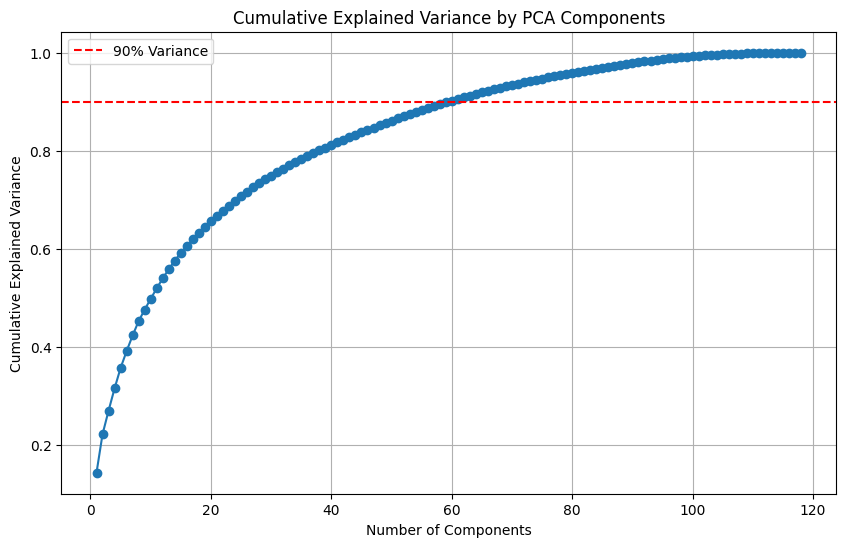

Optimal number of components: 60


In [5]:
# 3. Apply PCA to the training data and choose optimal number of components based on explained variance
pca = PCA().fit(X_train)

# Plot the cumulative explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
plt.legend()
plt.show()

# Choose the number of components that explain at least 90% of the variance
optimal_components = (cumulative_variance >= 0.90).argmax() + 1
print(f"Optimal number of components: {optimal_components}")

In [6]:
# 4. Apply PCA with the optimal number of components
pcr = make_pipeline(PCA(n_components=optimal_components), LinearRegression())

# 5. Fit the model with the training data
pcr.fit(X_train, y_train)

# 6. Make predictions on the test data
y_pred_pcr = pcr.predict(X_test)

# 7. Evaluate the model (Mean Squared Error and R-squared)
pcr1_mse = mean_squared_error(y_test, y_pred_pcr)
pcr1_r2 = r2_score(y_test, y_pred_pcr)

print(f'Mean Squared Error: {pcr1_mse}')
print(f'R-squared: {pcr1_r2}')

Mean Squared Error: 0.0967465668616854
R-squared: 0.04321920793429512


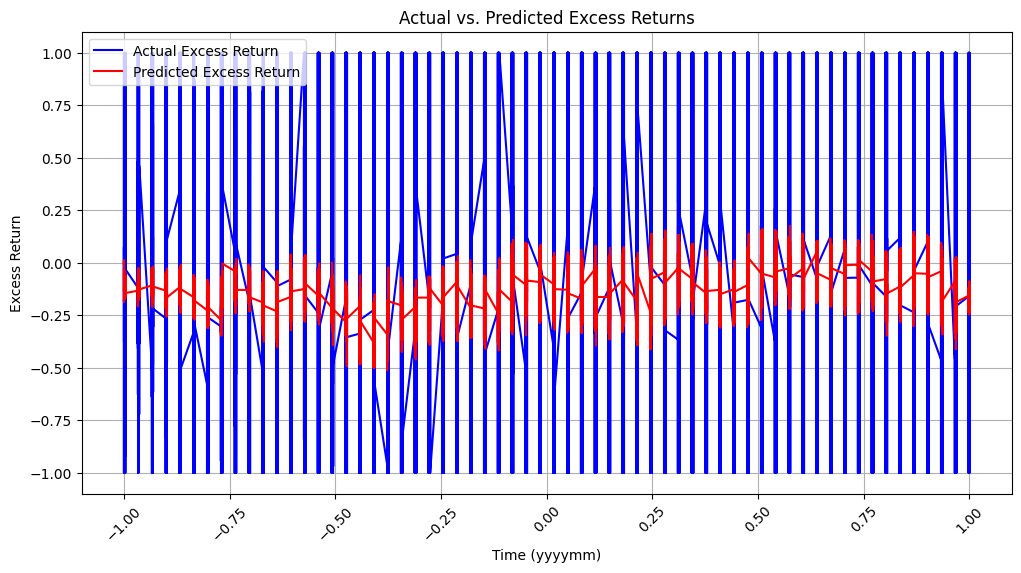

In [7]:
import matplotlib.pyplot as plt

df = subset_data.copy()

# Create a DataFrame for plotting
results_df = pd.DataFrame({'yyyymm': df.loc[X_test.index, 'yyyymm'].values, 
                           'Actual': y_test.values, 
                           'Predicted': y_pred_pcr})

# Sort by date for proper time series visualization
results_df = results_df.sort_values('yyyymm')

# Plot actual vs. predicted returns
plt.figure(figsize=(12, 6))
plt.plot(results_df['yyyymm'], results_df['Actual'], label='Actual Excess Return', color='blue')
plt.plot(results_df['yyyymm'], results_df['Predicted'], label='Predicted Excess Return', color='red')

plt.title('Actual vs. Predicted Excess Returns')
plt.xlabel('Time (yyyymm)')
plt.ylabel('Excess Return')
plt.xticks(rotation=45)  # Rotate x-axis for better readability
plt.legend()
plt.grid(True)
plt.show()


In [8]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (3697141, 118)
X_test shape: (943049, 118)


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression MSE: {mse_lr}, R^2: {r2_lr}")


Linear Regression MSE: 0.09678172270328474, R^2: 0.042871532196930184


In [10]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (3697141, 118)
X_test shape: (943049, 118)


5. Choosing top 20 features using RandomForest

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor


# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances for PCA components
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Select the top 20 most important PCA components
top_features = feature_importances.nlargest(20).index

# Reduce X_train and X_test to the top 20 PCA components
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

print("Reduced X_train shape:", X_train_reduced.shape)
print("Reduced X_test shape:", X_test_reduced.shape)


Reduced X_train shape: (3697141, 20)
Reduced X_test shape: (943049, 20)


In [12]:
X_train = X_train_reduced
X_test = X_test_reduced

In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")  # You can also try "median" or "most_frequent"
X_train_reduced = imputer.fit_transform(X_train_reduced)
X_test_reduced = imputer.transform(X_test_reduced)


6. FItting Models

In [14]:
from sklearn.preprocessing import PolynomialFeatures

# Apply polynomial features (degree 2) with interaction_only=True
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly_train = poly.fit_transform(X_train_reduced)
X_poly_test = poly.transform(X_test_reduced)

# Train Linear Regression Model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_poly_train, y_train)

# Make predictions
y_pred_poly = model.predict(X_poly_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_poly)
r2 = r2_score(y_test, y_pred_poly)

print(f"Polynomial Regression MSE: {mse}, R^2: {r2}")


Polynomial Regression MSE: 0.09725177306288281, R^2: 0.03822294186493436


In [15]:
poly2_mse = mse
poly2_r2 = r2

In [16]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Apply polynomial features with degree 2 (you can try degree 3 as well)
poly = PolynomialFeatures(degree=1)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Use Ridge Regression (with regularization)
ridge_model = Ridge(alpha=1.0)  # You can adjust alpha for more/less regularization
ridge_model.fit(X_poly_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_poly_test)

# Evaluate the model
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression MSE: {mse}, R^2: {r2}")


Ridge Regression MSE: 0.09725177306288281, R^2: 0.03822294186493436


In [17]:
from sklearn.linear_model import Lasso

# Initialize and fit the LASSO model
lasso_model = Lasso(alpha=0.001)  # You can adjust alpha for more/less regularization
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"LASSO Regression MSE: {mse_lasso}, R^2: {r2_lasso}")


LASSO Regression MSE: 0.09683193011748113, R^2: 0.04237500305816422


In [18]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)  # Adjust the number of splits as needed


In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
grid = GridSearchCV(ElasticNet(), param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid.fit(X_train, y_train)

best_en = grid.best_estimator_
y_pred_en = best_en.predict(X_test)

mse_en = mean_squared_error(y_test, y_pred_en)
r2_en = r2_score(y_test, y_pred_en)

print(f"Tuned Elastic Net - Best MSE: {mse_en}, Best R2: {r2_en}")


Tuned Elastic Net - Best MSE: 0.09680571199938903, Best R2: 0.042634288659796904


In [20]:
import time
import numpy as np
from sklearn.svm import LinearSVR
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Track time
start_time = time.time()

# Subset data for faster training
X_train_sample = X_train[:500000]  # Use 500K rows
y_train_sample = y_train[:500000]

# Define optimized hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10]
}

# Use HalvingGridSearchCV for faster tuning
grid = HalvingGridSearchCV(
    LinearSVR(max_iter=10000, random_state=42),  # More iterations for convergence
    param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,  # Reduce CV folds for speed
    n_jobs=-1  # Use all CPU cores
)

# Fit model
grid.fit(X_train_sample, y_train_sample)

# Get best model
best_svm = grid.best_estimator_

# Predict on full test set
y_pred_svm = best_svm.predict(X_test)

# Evaluate performance
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

# Print results
print(f"Tuned SVM Regression - Best MSE: {mse_svm:.4f}, Best R2: {r2_svm:.4f}")
print(f"Best hyperparameters: {grid.best_params_}")

# Track total time
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")


Tuned SVM Regression - Best MSE: 0.0961, Best R2: 0.0500
Best hyperparameters: {'C': 1}
Training Time: 109.48 seconds


In [21]:
print("Reduced X_train shape:", X_train.shape)
print("Reduced X_test shape:", X_test.shape)


Reduced X_train shape: (3697141, 20)
Reduced X_test shape: (943049, 20)


In [22]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Convert to float32 to reduce memory usage
X_train_df = X_train.astype(np.float32)
X_test_scaled = X_test.astype(np.float32)

# Optimized Random Forest Model
rf = RandomForestRegressor(
    n_estimators=20,          # Low tree count for speed
    max_depth=10,             # Prevent overfitting
    max_features="sqrt",      # Reduce features considered at each split
    bootstrap=False,          # Use full dataset (avoids sampling overhead)
    n_jobs=-1,                # Use all CPU cores
    warm_start=True,          # Allows incremental fitting if needed
    random_state=42
)

# Train the model
rf.fit(X_train_df, y_train)

# Predictions
y_pred_rf = rf.predict(X_test_scaled)

# Evaluation Metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Optimized MSE: {mse_rf}, Optimized R²: {r2_rf}")


Random Forest - Optimized MSE: 0.09478288621148422, Optimized R²: 0.06263914177597496


In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3, 5]}
grid = GridSearchCV(XGBRegressor(random_state=42, tree_method='hist'), 
                    param_grid, 
                    scoring='neg_mean_squared_error', 
                    cv=tscv, 
                    n_jobs=-1)  # Uses all CPU cores



grid.fit(X_train, y_train)

best_gb = grid.best_estimator_
y_pred_xgb = best_gb.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_xgb)
r2_gb = r2_score(y_test, y_pred_xgb)

print(f"Tuned Gradient Boosting - Best MSE: {mse_gb}, Best R2: {r2_gb}")


Tuned Gradient Boosting - Best MSE: 0.09346802642821203, Best R2: 0.07564252397033278


In [24]:
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
    'hidden_layer_sizes': [(50,), (75,)],
    'alpha': [1e-5, 1e-4, 1e-3],  
    'solver': ['adam']
}

grid = HalvingGridSearchCV(MLPRegressor(max_iter=1000, batch_size=5000, early_stopping=True, random_state=42), 
                           param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=tscv, 
                           n_jobs=-1, 
                           verbose=1)
grid.fit(X_train[:500000], y_train[:500000])  # Use only a subset for tuning

best_nn = grid.best_estimator_
y_pred_nn = best_nn.predict(X_test)

mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Tuned Neural Network - Best MSE: {mse_nn}, Best R2: {r2_nn}")


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 166666
max_resources_: 500000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 166666
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 1
n_candidates: 2
n_resources: 499998
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Tuned Neural Network - Best MSE: 0.09772479778703638, Best R2: 0.03354493638191458


7. Calculating CAPM baseline

In [25]:
from dateutil.relativedelta import relativedelta

# 1) DATA LOADING & PRE-PROCESSING

crsp_fp  = './crspm_and_predictors.csv'
df_crsp  = pd.read_csv(crsp_fp)
df_crsp.rename(columns={'yyyymm': 'signal_month'}, inplace=True)
df_crsp['signal_month'] = pd.to_datetime(df_crsp['signal_month'].astype(str), format='%Y%m')

# SHIFT next-month returns
df_crsp['yyyymm_return'] = df_crsp['signal_month'].apply(lambda d: d + relativedelta(months=1))
df_crsp['ret_decimal'] = df_crsp['ret'] / 100.0

# Load T-Bill and merge
tbill_fp = './TB3MS.csv'
df_tbill = pd.read_csv(tbill_fp)
df_tbill.rename(columns={'date': 'observation_date'}, inplace=True)
df_tbill['observation_date'] = pd.to_datetime(df_tbill['observation_date'])
df_tbill.rename(columns={'observation_date': 'yyyymm_return'}, inplace=True)

# Merge T-Bill onto CRSP
df_merged = pd.merge(
    df_crsp,
    df_tbill[['yyyymm_return','TB3MS']],
    how='left',
    on='yyyymm_return'
)

# monthly risk-free => decimal
df_merged['RF_monthly'] = (df_merged['TB3MS'] / 100.0) / 12.0
df_merged['excess_ret'] = df_merged['ret_decimal'] - df_merged['RF_monthly']

# Market cap from log(Size)
df_merged['mkt_cap'] = np.exp(df_merged['Size'])

# Drop missing essential data
df_merged.dropna(subset=['mkt_cap','ret_decimal'], inplace=True)
df_merged.sort_values(['signal_month','permno'], inplace=True)
print("After shifting returns & merging T-bill, shape:", df_merged.shape)

# Build value-weighted market factor
df_merged['total_mktcap'] = df_merged.groupby('signal_month')['mkt_cap'].transform('sum')
df_merged['weight'] = df_merged['mkt_cap'] / df_merged['total_mktcap']
df_merged['weighted_ret'] = df_merged['weight'] * df_merged['ret_decimal']

df_market = df_merged.groupby('signal_month', as_index=False)['weighted_ret'].sum()
df_market.rename(columns={'weighted_ret': 'market_ret'}, inplace=True)

df_market = pd.merge(
    df_market,
    df_merged[['signal_month','RF_monthly']].drop_duplicates(),
    on='signal_month',
    how='left'
)
df_market['mkt_excess_ret'] = df_market['market_ret'] - df_market['RF_monthly']

df_final = pd.merge(
    df_merged,
    df_market[['signal_month','mkt_excess_ret']],
    on='signal_month',
    how='left'
)
df_final.dropna(subset=['excess_ret','mkt_excess_ret'], inplace=True)
print("Final dataset shape:", df_final.shape)


After shifting returns & merging T-bill, shape: (4618691, 125)
Final dataset shape: (4618691, 129)


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 10197 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 10760 due to insufficient data
Skipping stock 10954 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 11780 due to insufficient data
Skipping stock 11848 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 12346 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 13010 due to insufficient data
Skipping stock 13011 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 13427 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 15094 due to insufficient data
Skipping stock 15158 due to insufficient data
Skipping stock 15174 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 22761 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 24899 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 25661 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 25773 due to insufficient data
Skipping stock 25775 due to insufficient data
Skipping stock 25776 due to insufficient data
Skipping stock 25779 due to insufficient data
Skipping stock 25780 due to insufficient data
Skipping stock 25781 due to insufficient data
Skipping stock 25782 due to insufficient data
Skipping stock 25783 due to insufficient data
Skipping stock 25784 due to insufficient data
Skipping stock 25789 due to insufficient data
Skipping stock 25790 due to insufficient data
Skipping stock 25791 due to insufficient data
Skipping stock 25792 due to insufficient data
Skipping stock 25795 due to insufficient data
Skipping stock 25796 due to insufficient data
Skipping stock 25797 due to insufficient data
Skipping stock 25798 due to insufficient data
Skipping stock 25799 due to insufficient data
Skipping stock 25800 due to insufficient data
Skipping stock 25801 due to insufficient data
Skipping stock 25802 due to insufficient data
Skipping stock 25803 due to insuff

c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 33355 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 34570 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 37081 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 38202 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 39627 due to insufficient data
Skipping stock 40775 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 42594 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 43319 due to insufficient data
Skipping stock 43482 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 48304 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 50009 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 54712 due to insufficient data
Skipping stock 54739 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 59708 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 63272 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 66895 due to insufficient data
Skipping stock 67302 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 68268 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 77031 due to insufficient data
Skipping stock 77033 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 77455 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 77994 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 78245 due to insufficient data
Skipping stock 78312 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 78427 due to insufficient data
Skipping stock 78585 due to insufficient data
Skipping stock 78654 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 81462 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 82414 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 83380 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Skipping stock 84370 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 86798 due to insufficient data
Skipping stock 86875 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 88506 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 90848 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

Skipping stock 92799 due to insufficient data


c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sethi\AppData\Local\Programs\Python\Python3

             permno         alpha          beta           mse            r2
count  38084.000000  38084.000000  38084.000000  3.808400e+04  3.729600e+04
mean   52106.039518      0.010117      0.512432  2.518275e-01 -9.274246e+04
std    30439.350757      0.640271    133.505034  1.668301e+01  1.391924e+07
min    10000.000000    -45.310154  -7070.145581  3.009266e-36 -2.660531e+09
25%    20750.750000      0.001716      0.203549  4.736807e-03 -2.838945e-01
50%    54021.500000      0.013930      0.649968  1.652351e-02 -4.235490e-02
75%    82170.250000      0.029024      1.201754  5.063827e-02  6.515965e-02
max    93436.000000     61.565786  14715.280000  2.944696e+03  1.000000e+00

Overall CAPM Model - Avg MSE: 0.251828, Avg R²: nan


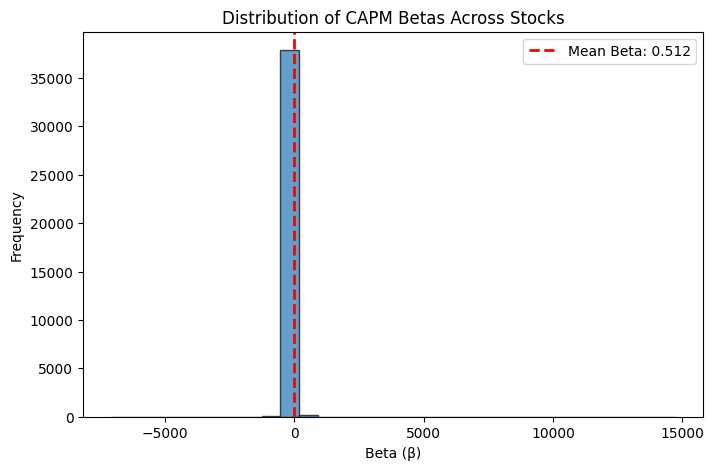

In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Initialize lists for storing CAPM results
alpha_list = []
beta_list = []
mse_list = []
r2_list = []
permno_list = []  # To ensure mapping stays correct

# CAPM Baseline Model: Train separately for each stock (permno)
for permno, group in df_final.groupby('permno'):
    group = group.sort_values('signal_month')  # Ensure chronological order

    # Split into training and testing (80-20 split)
    train_size = int(len(group) * 0.8)
    train_data_capm = group[:train_size]
    test_data_capm = group[train_size:]

    # Skip stocks with insufficient data
    if train_data_capm.empty or test_data_capm.empty:
        print(f"Skipping stock {permno} due to insufficient data")
        continue

    # Define features and target
    X_train_capm = train_data_capm['mkt_excess_ret']
    y_train_capm = train_data_capm['excess_ret']
    X_test_capm = test_data_capm['mkt_excess_ret']
    y_test_capm = test_data_capm['excess_ret']

    # Ensure there are no NaN values
    if X_train_capm.isna().any() or y_train_capm.isna().any():
        #print(f"Skipping stock {permno} due to NaN values")
        continue

    # Add intercept for CAPM regression
    X_train_capm = sm.add_constant(X_train_capm, has_constant='add')
    X_test_capm = sm.add_constant(X_test_capm, has_constant='add')

    # Run OLS regression
    model = sm.OLS(y_train_capm, X_train_capm).fit()

    # Store Alpha & Beta
    alpha, beta = model.params['const'], model.params['mkt_excess_ret']
    alpha_list.append(alpha)
    beta_list.append(beta)
    permno_list.append(permno)  # Ensure permno is stored only for valid stocks

    # Predictions
    y_pred_capm = model.predict(X_test_capm)

    # Calculate metrics
    mse_capm = mean_squared_error(y_test_capm, y_pred_capm)
    r2_capm = r2_score(y_test_capm, y_pred_capm)

    mse_list.append(mse_capm)
    r2_list.append(r2_capm)

# Store results in DataFrame
capm_results = pd.DataFrame({'permno': permno_list,
                             'alpha': alpha_list,
                             'beta': beta_list,
                             'mse': mse_list,
                             'r2': r2_list})

# Display summary statistics
print(capm_results.describe())

# Overall CAPM Performance
print(f"\nOverall CAPM Model - Avg MSE: {np.mean(mse_list):.6f}, Avg R²: {np.mean(r2_list):.6f}")

# Plot distribution of betas
plt.figure(figsize=(8, 5))
plt.hist(beta_list, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(beta_list), color='red', linestyle='dashed', linewidth=2, label=f"Mean Beta: {np.mean(beta_list):.3f}")
plt.xlabel("Beta (β)")
plt.ylabel("Frequency")
plt.title("Distribution of CAPM Betas Across Stocks")
plt.legend()
plt.show()


8. Diebold-Mariano (DM) Test

In [27]:
import numpy as np
from scipy import stats

def dm_test(actual, forecast1, forecast2, h=1, alternative="two-sided"):
    """
    Perform the Diebold-Mariano test to compare the predictive accuracy of two forecasts.

    Parameters:
    - actual: Array of actual values
    - forecast1: Array of predicted values from model 1
    - forecast2: Array of predicted values from model 2
    - h: Forecast horizon (default is 1)
    - alternative: 'two-sided', 'less', or 'greater'

    Returns:
    - DM test statistic
    - p-value
    """
    # Compute forecast errors
    e1 = actual - forecast1
    e2 = actual - forecast2

    # Compute loss differential (Squared Error Loss)
    d = (e1**2) - (e2**2)

    # Mean and variance of the loss differential
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)

    # Compute test statistic
    T = len(d)
    DM_stat = mean_d / np.sqrt(var_d / T)

    # Compute p-value
    if alternative == "two-sided":
        p_value = 2 * (1 - stats.t.cdf(abs(DM_stat), df=T - 1))
    elif alternative == "greater":
        p_value = 1 - stats.t.cdf(DM_stat, df=T - 1)
    elif alternative == "less":
        p_value = stats.t.cdf(DM_stat, df=T - 1)
    else:
        raise ValueError("alternative should be 'two-sided', 'less', or 'greater'")

    return DM_stat, p_value



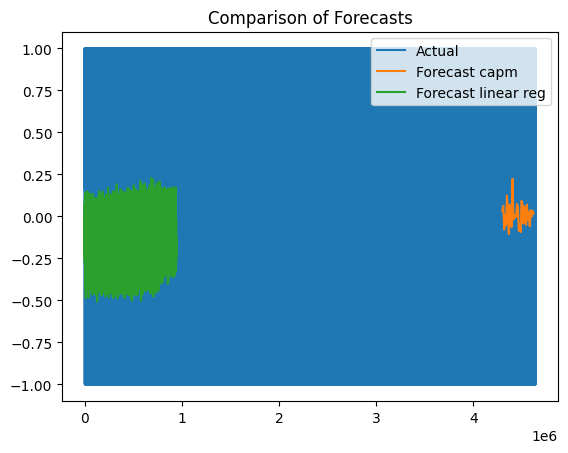

MSE Model 1: 0.0920836717730513, MSE Model 2: 0.09678172270328474
DM Test Statistic: 1145.8765995263584, P-Value: 0.0


In [28]:
import matplotlib.pyplot as plt

plt.plot(y_test, label="Actual")
plt.plot(y_pred_capm, label="Forecast capm")
plt.plot(y_pred_lr, label="Forecast linear reg")
plt.legend()
plt.title("Comparison of Forecasts")
plt.show()

mse1 = np.mean((y_test - y_pred_capm) ** 2)
mse2 = np.mean((y_test - y_pred_lr) ** 2)
print(f"MSE Model 1: {mse1}, MSE Model 2: {mse2}")

dm_stat, p_val = dm_test(y_test, y_pred_capm, y_pred_lr)
print(f"DM Test Statistic: {dm_stat}, P-Value: {p_val}")


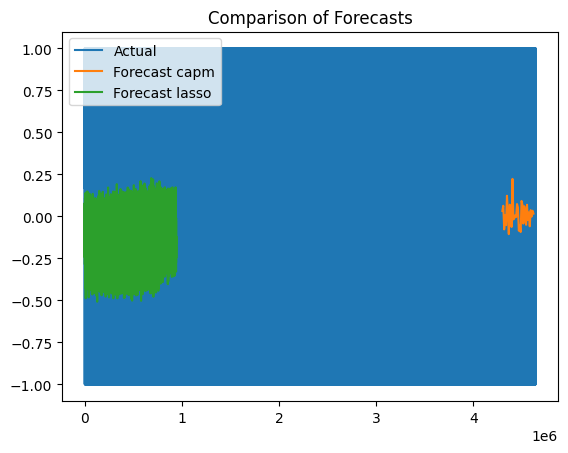

MSE Model 1: 0.0920836717730513, MSE Model 2: 0.09683193011748113
DM Test Statistic: 997.5580818154298, P-Value: 0.0


In [29]:
import matplotlib.pyplot as plt

plt.plot(y_test, label="Actual")
plt.plot(y_pred_capm, label="Forecast capm")
plt.plot(y_pred_lr, label="Forecast lasso")
plt.legend()
plt.title("Comparison of Forecasts")
plt.show()

mse1 = np.mean((y_test - y_pred_capm) ** 2)
mse2 = np.mean((y_test - y_pred_lasso) ** 2)
print(f"MSE Model 1: {mse1}, MSE Model 2: {mse2}")

dm_stat, p_val = dm_test(y_test, y_pred_capm, y_pred_lasso)
print(f"DM Test Statistic: {dm_stat}, P-Value: {p_val}")


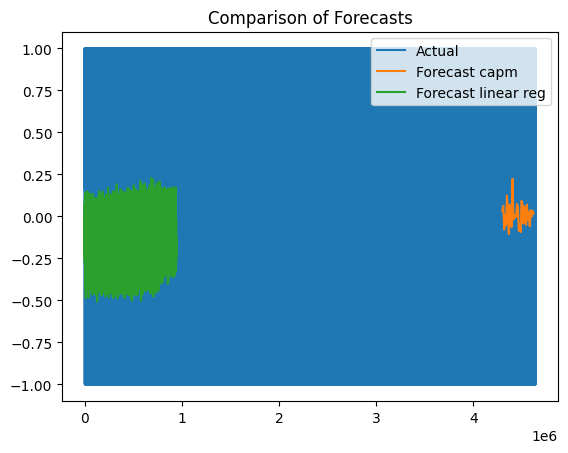

MSE Model 1: 0.0920836717730513, MSE Model 2: 0.09680571199938903
DM Test Statistic: 1123.9949926793379, P-Value: 0.0


In [30]:
import matplotlib.pyplot as plt

plt.plot(y_test, label="Actual")
plt.plot(y_pred_capm, label="Forecast capm")
plt.plot(y_pred_lr, label="Forecast linear reg")
plt.legend()
plt.title("Comparison of Forecasts")
plt.show()

mse1 = np.mean((y_test - y_pred_capm) ** 2)
mse2 = np.mean((y_test - y_pred_en) ** 2)
print(f"MSE Model 1: {mse1}, MSE Model 2: {mse2}")

dm_stat, p_val = dm_test(y_test, y_pred_capm, y_pred_en)
print(f"DM Test Statistic: {dm_stat}, P-Value: {p_val}")


In [32]:
import numpy as np
from scipy.stats import norm

def sharpe_ratio_test(excess1, excess2):
    """
    Performs a statistical test to compare the Sharpe ratios of two investment strategies.
    
    Parameters:
    - returns1: np.array, returns of strategy 1
    - returns2: np.array, returns of strategy 2
    - risk_free_rate: float, risk-free rate (default is 0)
    
    Returns:
    - Sharpe Ratio 1
    - Sharpe Ratio 2
    - Test Statistic
    - P-value
    """
    
  
    # Compute Sharpe ratios
    sharpe1 = np.mean(excess1) / np.std(excess1, ddof=1)
    sharpe2 = np.mean(excess2) / np.std(excess2, ddof=1)
    
    # Compute variance of Sharpe ratio difference
    n = len(returns1)
    var1 = np.var(excess1, ddof=1)
    var2 = np.var(excess2, ddof=1)
    cov12 = np.cov(excess1, excess2)[0, 1]
    
    # Standard error of the Sharpe ratio difference
    se_diff = np.sqrt((var1 / n) + (var2 / n) - (2 * cov12 / n))
    
    # Test statistic
    test_stat = (sharpe1 - sharpe2) / se_diff
    
    # P-value (two-tailed test)
    p_value = 2 * (1 - norm.cdf(abs(test_stat)))
    
    return sharpe1, sharpe2, test_stat, p_value


returns1 = y_pred_lasso
returns2 = y_pred_lr  # Replace with your second model's predictions

sharpe1, sharpe2, test_stat, p_value = sharpe_ratio_test(returns1, returns2)

print(f"Sharpe Ratio lasso: {sharpe1:.4f}")
print(f"Sharpe Ratio elastic net: {sharpe2:.4f}")

returns1 = y_pred_lr
returns2 = y_pred_nn  # Replace with your second model's predictions

sharpe1, sharpe2, test_stat, p_value = sharpe_ratio_test(returns1, returns2)

print(f"Sharpe Ratio linear regression {sharpe1:.4f}")
print(f"Sharpe Ratio neural network: {sharpe2:.4f}")

returns1 = y_pred_rf
returns2 = y_pred_svm  # Replace with your second model's predictions

sharpe1, sharpe2, test_stat, p_value = sharpe_ratio_test(returns1, returns2)

print(f"Sharpe Ratio random forest: {sharpe1:.4f}")
print(f"Sharpe Ratio SVM: {sharpe2:.4f}")

returns1 = y_pred_ridge
returns2 = y_pred_pcr  # Replace with your second model's predictions

sharpe1, sharpe2, test_stat, p_value = sharpe_ratio_test(returns1, returns2)

print(f"Sharpe Ratio Ridge regression: {sharpe1:.4f}")
print(f"Sharpe Ratio PCR: {sharpe2:.4f}")

returns1 = y_pred_xgb
returns2 = y_test  # Replace with your second model's predictions

sharpe1, sharpe2, test_stat, p_value = sharpe_ratio_test(returns1, returns2)

print(f"Sharpe Ratio XGB: {sharpe1:.4f}")
print(f"Sharpe Ratio Actual: {sharpe2:.4f}")


Sharpe Ratio lasso: -1.8909
Sharpe Ratio elastic net: -1.6412
Sharpe Ratio linear regression -1.6412
Sharpe Ratio neural network: -1.3131
Sharpe Ratio random forest: -1.8836
Sharpe Ratio SVM: -1.9669
Sharpe Ratio Ridge regression: -1.7080
Sharpe Ratio PCR: -1.6475
Sharpe Ratio XGB: -1.4082
Sharpe Ratio Actual: -0.4299


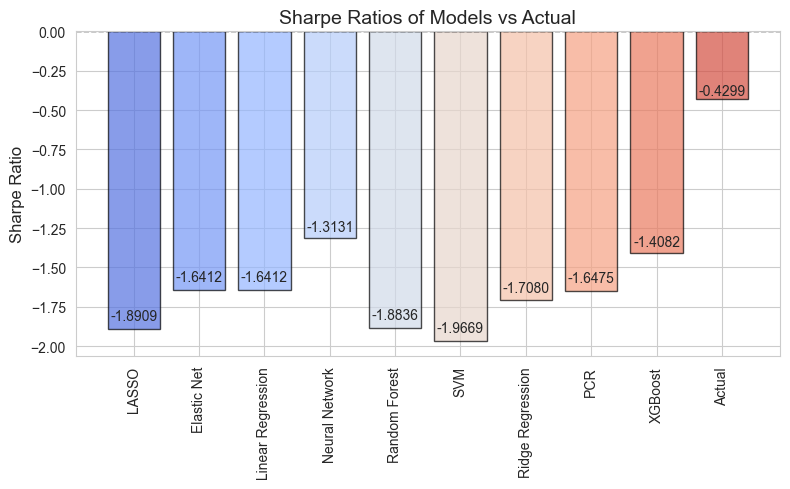

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sharpe Ratio values
sharpe_ratios = {
    "LASSO": -1.8909,
    "Elastic Net": -1.6412,
    "Linear Regression": -1.6412,
    "Neural Network": -1.3131,
    "Random Forest": -1.8836,
    "SVM": -1.9669,
    "Ridge Regression": -1.7080,
    "PCR": -1.6475,
    "XGBoost": -1.4082,
    "Actual": -0.4299
}

# Extract names and values
models = list(sharpe_ratios.keys())
values = list(sharpe_ratios.values())

# Set plot style
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

# Create bar plot
colors = sns.color_palette("coolwarm", len(values))
bars = plt.bar(models, values, color=colors, alpha=0.7, edgecolor='black')

# Add title and labels
plt.title("Sharpe Ratios of Models vs Actual", fontsize=14)
plt.ylabel("Sharpe Ratio", fontsize=12)

# Add horizontal line at Sharpe Ratio = 0
plt.axhline(y=0, color='black', linewidth=1, linestyle="--")

# Annotate each bar with its value
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02 * abs(val), 
             f"{val:.4f}", ha='center', va='bottom', fontsize=10)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
